<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/NLP/DZ_2_text_classification_rnn_glow_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Для закрепления материала модуля предлагаем вам поучаствовать в учебном [Kaggle-соревновании](https://www.kaggle.com/competitions/unit-3-nlp-txt-classification/data).

Вам необходимо решить задачу классификации текстов, используя рекуррентные сети.
______

При выполнении проекта разрешается пользоваться любыми средствами для векторных представлений текстов, кроме трансформеров, и любыми вариантами рекуррентных сетей. Для достижения наилучшего результата уделите внимание подбору гиперапарметров как в плане архитектуры, так и в плане обучения модели.
______

Критерии самооценивания проекта:

- общее качество кода и следование PEP-8;
- использование рекуррентных сетей;
- итоговое значение метрики качества.

# Подключение к Kaggle

In [ ]:
api_token = {"username":"...", "key":"..."}

import json

with open('/content/kaggle.json', 'w') as file:
  json.dump(api_token, file)

In [ ]:
# Загрузка датасета с Кеггла
!pip install kaggle -q
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.12 -q
!kaggle --version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Kaggle API 1.5.12


# Загрузка данных соревнования

In [ ]:
!kaggle competitions download -c unit-3-nlp-txt-classification
!unzip '/content/unit-3-nlp-txt-classification.zip' -d'/content/data/'

  0% 0.00/4.08M [00:00<?, ?B/s]
100% 4.08M/4.08M [00:00<00:00, 47.5MB/s]
Archive:  /content/unit-3-nlp-txt-classification.zip
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

os.listdir() # корневая папка

['.config',
 'unit-3-nlp-txt-classification.zip',
 'kaggle.json',
 'data',
 'sample_data']

## Читаем все в датафреймы.

In [ ]:
INPUT_PATH = '/content/data'  # папка с данными
# данные для обучения
main_ds = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'), index_col=0)
# тестовые данные
test_ds = pd.read_csv(os.path.join(INPUT_PATH, 'test.csv'), index_col=0)
# пример для загрузки ответов
sample_submission = pd.read_csv(os.path.join(INPUT_PATH, 'sample_submission.csv'))
# размер данных
main_ds.shape, test_ds.shape, sample_submission.shape

((41159, 2), (3798, 1), (3798, 2))

In [ ]:
# train dataset
main_ds.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
main_ds.sample(1).Text.tolist()[0]

'Global #OilPrices Plunge to 17-Year-Low at $25.08 Per Barrel Amid #Coronavirus Outbreak, Experts See Worldwide #Recession Soon\r\r\nhttps://t.co/IdVhVcXem6'

In [ ]:
# train dataset Sentiment.value_counts()
main_ds.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [ ]:
# test dataset
main_ds.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# sample_submission
print(sample_submission.Sentiment.value_counts())
print()
sample_submission.head()


Neutral    3798
Name: Sentiment, dtype: int64



,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Neutral
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Neutral
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Neutral
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Neutral
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


## Импорты и константы

In [ ]:
import time
import re
from tqdm import tqdm



In [ ]:
NUM_CLASSES = len(main_ds.Sentiment.value_counts().index)
print(f'NUM_CLASSES = {NUM_CLASSES}')


NUM_CLASSES = 5


## Чистка и предобработка

In [ ]:
# пропуски
main_ds.isna().sum()

Text         1
Sentiment    4
dtype: int64

Есть совсем немного (от 4 до 6) NaNов в 41159 строках. Проще от них избавиться.

In [ ]:
# удаляем
main_ds = main_ds.dropna()
main_ds.isna().sum()

Text         0
Sentiment    0
dtype: int64

## Есть ли баланс в данных?

Extremely Negative     5481
Extremely Positive     6624
Negative               9917
Neutral                7711
Positive              11422
Name: Sentiment, dtype: int64


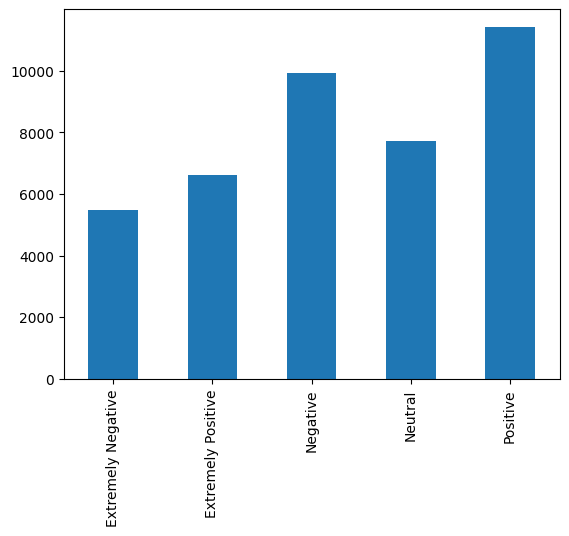

In [ ]:
# давайте посмотрим распределение оценок
import matplotlib.pyplot as plt
%matplotlib inline
# value_counts () - a command that allows you to calculate the number of unique values
vc = main_ds.Sentiment.value_counts()
vc = vc.sort_index()
print(vc)
vc.plot(kind='bar');

Самый частый класс больше самого редкого в два раза. Пока как есть пробуем.

На следующем этаме можно добавить аугментацию

Посмотрим на длину текстов.

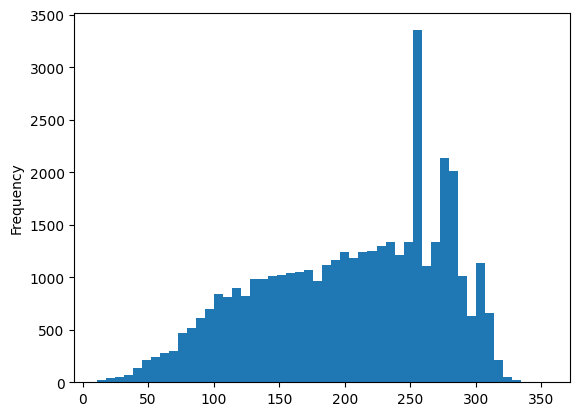

In [ ]:
lens = main_ds.Text.apply(lambda s: len(s))
lens.plot.hist(bins=50);

In [ ]:
lens.quantile(0.95), max(lens)

(300.0, 355)

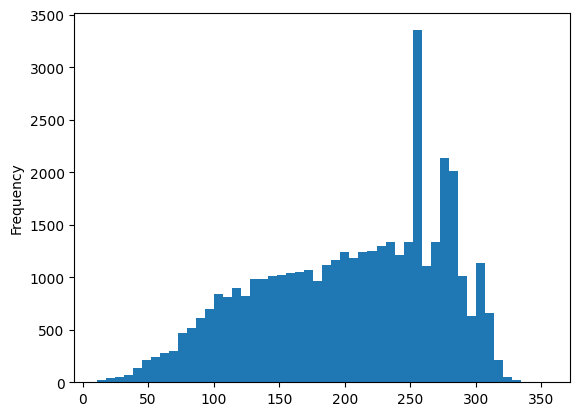

In [ ]:
lens = main_ds.Text.apply(lambda s: len(s))
lens.plot.hist(bins=50);

In [ ]:
lens.quantile(0.95), max(lens)

(300.0, 355)

# Sentences cleaning

Подберем то, что мы очищаем в данных

## abbreviaturs clearning

In [ ]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired",
}

In [ ]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev(text):
    text = text.replace("Â", "'")
    return abbreviations[text] if text in abbreviations.keys() else text

In [ ]:
#sentence = main_ds.sample().Text.values[0]
sentence = "So now weÂre NOT supposed to go to the grocery store??  Really? Did I miss this before? #TrumpPressBriefing #COVID2019"
print(sentence)
print()
sentence = convert_abbrev(sentence)
print(sentence)

So now weÂre NOT supposed to go to the grocery store??  Really? Did I miss this before? #TrumpPressBriefing #COVID2019

So now we're NOT supposed to go to the grocery store??  Really? Did I miss this before? #TrumpPressBriefing #COVID2019


## Phrases with apostrophes

Словосочетания с апострофами в английском лушче раскрыть.

In [ ]:
contraction_dict = {"ain't": "is not",
                    "aren't": "are not",
                    "can't": "can not",
                    "'cause": "because",
                    "could've": "could have",
                    "couldn't": "could not",
                    "didn't": "did not",
                    "doesn't": "does not",
                    "don't": "do not",
                    "hadn't": "had not",
                    "hasn't": "has not",
                    "haven't": "have not",
                    "he'd": "he would",
                    "he'll": "he will",
                    "he's": "he is",
                    "how'd": "how did",
                    "how'd'y": "how do you",
                    "how'll": "how will",
                    "how's": "how is",
                    "I'd": "I would",
                    "I'd've": "I would have",
                    "I'll": "I will",
                    "I'll've": "I will have",
                    "I'm": "I am",
                    "I've": "I have",
                    "i'd": "i would",
                    "i'd've": "i would have",
                    "i'll": "i will",
                    "i'll've": "i will have",
                    "i'm": "i am",
                    "i've": "i have",
                    "isn't": "is not",
                    "it'd": "it would",
                    "it'd've": "it would have",
                    "it'll": "it will",
                    "it'll've": "it will have",
                    "it's": "it is",
                    "let's": "let us",
                    "ma'am": "madam",
                    "mayn't": "may not",
                    "might've": "might have",
                    "mightn't": "might not",
                    "mightn't've": "might not have",
                    "must've": "must have",
                    "mustn't": "must not",
                    "mustn't've": "must not have",
                    "needn't": "need not",
                    "needn't've": "need not have",
                    "o'clock": "of the clock",
                    "oughtn't": "ought not",
                    "oughtn't've": "ought not have",
                    "shan't": "shall not",
                    "sha'n't": "shall not",
                    "shan't've": "shall not have",
                    "she'd": "she would",
                    "she'd've": "she would have",
                    "she'll": "she will",
                    "she'll've": "she will have",
                    "she's": "she is",
                    "should've": "should have",
                    "shouldn't": "should not",
                    "shouldn't've": "should not have",
                    "so've": "so have",
                    "so's": "so as",
                    "this's": "this is",
                    "that'd": "that would",
                    "that'd've": "that would have",
                    "that's": "that is",
                    "there'd": "there would",
                    "there'd've": "there would have",
                    "there's": "there is",
                    "here's": "here is",
                    "they'd": "they would",
                    "they'd've": "they would have",
                    "they'll": "they will",
                    "they'll've": "they will have",
                    "they're": "they are",
                    "they've": "they have",
                    "to've": "to have",
                    "wasn't": "was not",
                    "we'd": "we would",
                    "we'd've": "we would have",
                    "we'll": "we will",
                    "we'll've": "we will have",
                    "we're": "we are",
                    "we've": "we have",
                    "weren't": "were not",
                    "what'll": "what will",
                    "what'll've": "what will have",
                    "what're": "what are",
                    "what's": "what is",
                    "what've": "what have",
                    "when's": "when is",
                    "when've": "when have",
                    "where'd": "where did",
                    "where's": "where is",
                    "where've": "where have",
                    "who'll": "who will",
                    "who'll've": "who will have",
                    "who's": "who is",
                    "who've": "who have",
                    "why's": "why is",
                    "why've": "why have",
                    "will've": "will have",
                    "won't": "will not",
                    "won't've": "will not have",
                    "would've": "would have",
                    "wouldn't": "would not",
                    "wouldn't've": "would not have",
                    "y'all": "you all",
                    "y'all'd": "you all would",
                    "y'all'd've": "you all would have",
                    "y'all're": "you all are",
                    "y'all've": "you all have",
                    "you'd": "you would",
                    "you'd've": "you would have",
                    "you'll": "you will",
                    "you'll've": "you will have",
                    "you're": "you are",
                    "you've": "you have"}

In [ ]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def convert_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

##Removing Emojis

In [ ]:
#Removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
sentence = main_ds.sample().Text.values[0]
print(sentence)
print()
print(remove_emoji(sentence))

Check out @Gartner_SC #podcast to better understand the #COVID19 impacts felt by consumer products supply chains and actions they should take.Listen now. #SupplyChain #GartnerSC https://t.co/dTZxvwIBkK

Check out @Gartner_SC #podcast to better understand the #COVID19 impacts felt by consumer products supply chains and actions they should take.Listen now. #SupplyChain #GartnerSC https://t.co/dTZxvwIBkK


## Remove special characters

In [ ]:
import string
from bs4 import BeautifulSoup
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [ ]:
sentence = main_ds.sample().Text.values[0]
print(sentence)
print()
print(denoise_text(sentence))


Avoid touching your face. https://t.co/pdhJl6uILA


Avoid touching your face. https://t.co/pdhJl6uILA


In [ ]:
def remove_special_characters(text, remove_digits=True):
    text = re.sub('http://\S+|https://\S+|www.\S+|\n|#|\r', '', text)
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text.strip()

In [ ]:
print(sentence)
print()
remove_special_characters(sentence)


Avoid touching your face. https://t.co/pdhJl6uILA



'Latest in the prevention of COVID with more st Care Hand Sanitizers in Stock online for convenient shopping and no waiting period at  Avoid touching your face'

In [ ]:
#sentence =
#'''
#Pakistan's biggest online shopping platforms @darazpk is acting responsibly by following the WHO's guidelines for COVID-19 in delivering their packages
#
##StaySafeShopOnline
#'''
#sentence ='''
#Indonesia - 227 cases, 19 deaths
#Philippines - 187 cases, 14 deaths
#Malaysia - 673 cases, 2 deaths
#Thailand - 177 cases, 1 death
#Singapore - 226 cases , 0 deaths

#Indonesia now has the most #COVID19 case fatalities in Southeast Asia #coronavirus #CoronaOutbreak #SARSCoV2
#'''
sentence = main_ds.sample().Text.values[0]
print(sentence)
print()
remove_special_characters(sentence)

COVID-19 pandemic accelerates new online shopping patterns for grocery chains and food suppliers. @PicknPay @Shoprite_SA @MassmartSA @Makro_SA @payflex https://t.co/DI5cYXOub9



'COVID pandemic accelerates new online shopping patterns for grocery chains and food suppliers PicknPay Shoprite_SA MassmartSA Makro_SA payflex'

## Removing the stopwords

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.tokenize import NLTKWordTokenizer
from nltk.corpus import stopwords
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Removing the stopwords
#def remove_stopwords(text):
    #tokenizer = NLTKWordTokenizer()
    #tokens = tokenizer.tokenize(text)
    #tokens = [token.strip() for token in tokens]
    #filtered_tokens = [token for token in tokens if token not in stopword_list]
    #filtered_text = ' '.join(filtered_tokens)
    #return filtered_text

In [ ]:
#sentence = main_ds.sample().Text.values[0]
#print(sentence)
#print()
#remove_stopwords(sentence)

## Mix clearing

In [ ]:
#Collect all functions
#def clean_text(text):
    #text = text.lower() #Lets make it lowercase
    #text = remove_emoji(text)
    #text = convert_abbrev(text)
    #text = remove_special_characters(text)
    #text = denoise_text(text)
    #text = remove_stopwords(text)
    #return text

In [ ]:
#Removing URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [ ]:
#Collect all functions
def clean_text(text):
    text = text.lower() #Lets make it lowercase
    text = remove_URL(text)
    text = remove_emoji(text)
    text = denoise_text(text)
    text = convert_abbrev(text)
    #text = remove_stopwords(text)
    text = remove_punct(text)
    text = remove_special_characters(text)
    return text

In [ ]:
sentence = main_ds.sample().Text.values[0]
print(sentence)
print()
print(clean_text(sentence))


https://t.co/7WresKSZEC https://t.co/yPpfKjpZjZ

double whammy covid reduced oil demand and failure of opec and nonopec groups to cut production levels halved prices since january  oilprices oilpricewar


In [ ]:
%timeit
main_ds['Text_clean'] = main_ds['Text'].apply(clean_text)
test_ds['Text_clean'] = test_ds['Text'].apply(clean_text)
main_ds.head()

,Text,Sentiment,Text_clean
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie philgahan chrisitv and and
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...


# Look again

In [ ]:
def length(text):
    '''a function which returns the length of text'''
    return len(text)

Сьлвари для первода из имени класса в номер класса и обратно

In [ ]:
dict_lbl_to_sent = {k: v for k, v in enumerate(main_ds['Sentiment'].unique())}
dict_sent_to_lbl = {v: k for k, v in dict_lbl_to_sent.items()}
print(f'Encoded sentiment values: {dict_sent_to_lbl}')

Encoded sentiment values: {'Neutral': 0, 'Positive': 1, 'Extremely Negative': 2, 'Negative': 3, 'Extremely Positive': 4}


Добавим номера классов

In [ ]:
main_ds['Label'] = main_ds['Sentiment'].apply(lambda x: dict_sent_to_lbl[x])

Добавим длину текстов

In [ ]:
main_ds['length_text_clean'] = main_ds['Text_clean'].apply(length)
test_ds['length_text_clean'] = test_ds['Text_clean'].apply(length)

## Number of characters in text

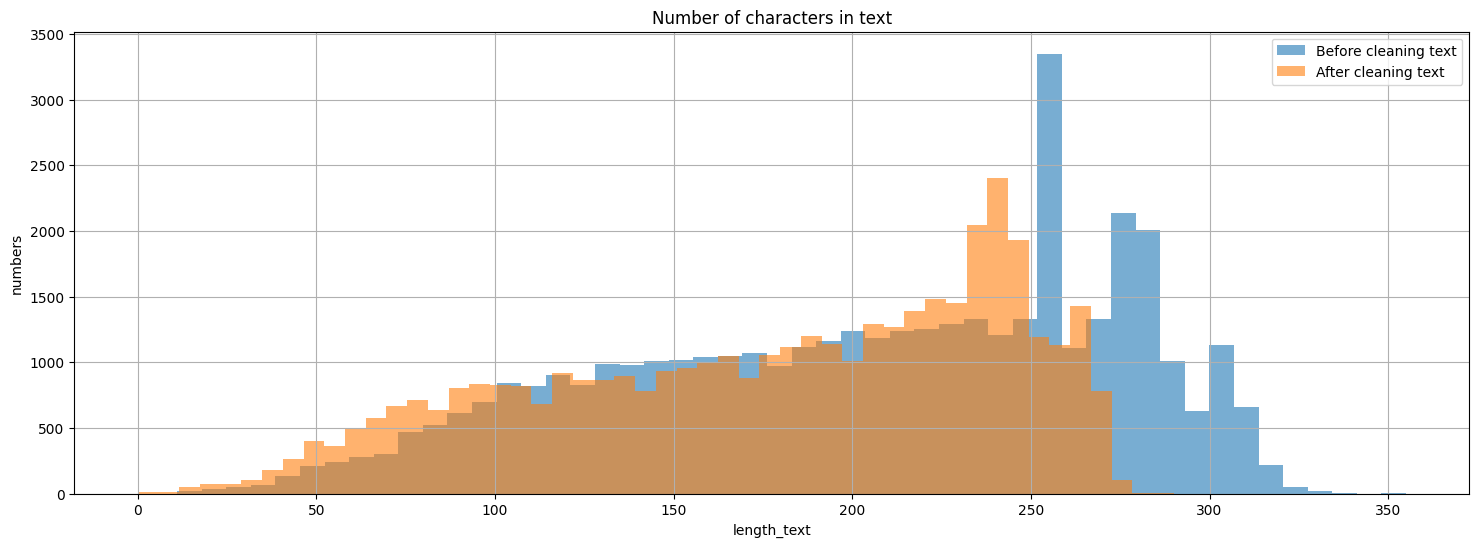

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 50
plt.hist(main_ds.Text.apply(length), alpha = 0.6, bins=bins, label='Before cleaning text')
plt.hist(main_ds['length_text_clean'], alpha = 0.6, bins=bins, label='After cleaning text')
plt.xlabel('length_text')
plt.ylabel('numbers')
plt.title('Number of characters in text')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Number of words in a text

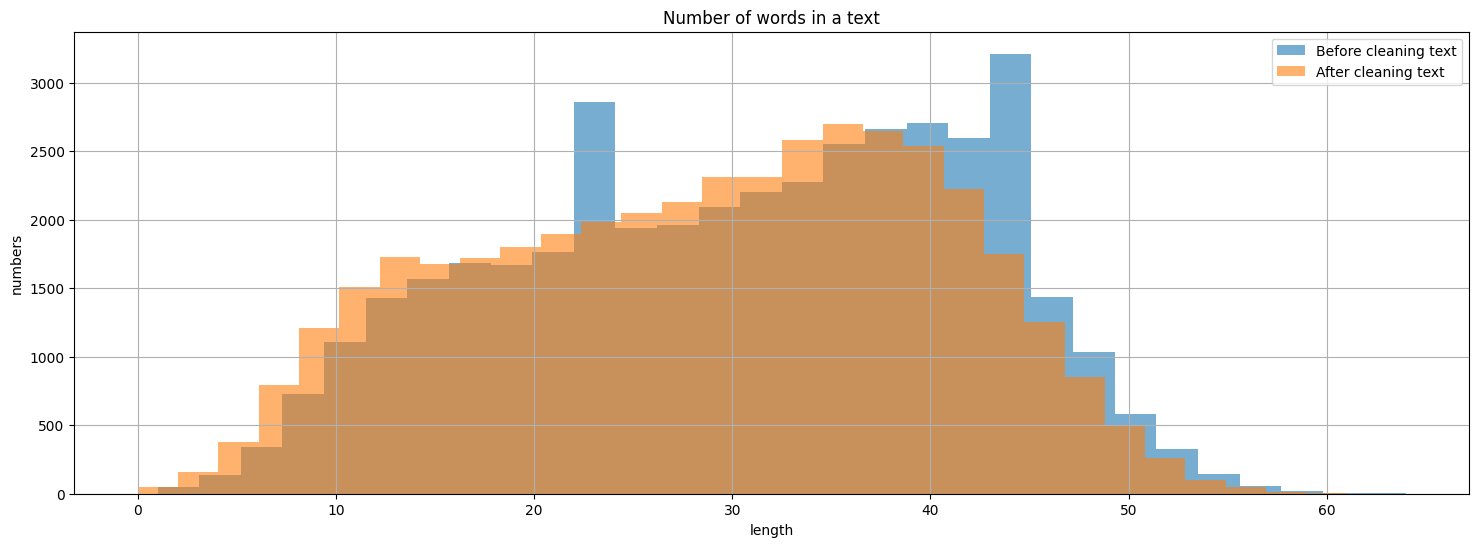

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 30
text_len=main_ds['Text'].str.split().map(lambda x: len(x))
text_len_clean=main_ds['Text_clean'].str.split().map(lambda x: len(x))
plt.hist(text_len, alpha = 0.6, bins=bins, label='Before cleaning text')
plt.hist(text_len_clean, alpha = 0.6, bins=bins, label='After cleaning text')
plt.xlabel('length')
plt.ylabel('numbers')
plt.title('Number of words in a text')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Removing blank lines


In [ ]:
main_ds[main_ds.length_text_clean == 0]

,Text,Sentiment,Text_clean,Label,length_text_clean
16,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,Neutral,,0,0
583,#????_???_?????? ???? ???????..? ?? ?????? ?? ...,Neutral,,0,0
2385,?? ??? ???. ????????-????? ?????? 3 ??????????...,Neutral,,0,0
5214,???? ???????? ??????????? - ???????? ?????????...,Neutral,,0,0
8841,????? ? ????? ?? ?????: ??????????? ??? ?? ???...,Neutral,,0,0
13843,? ???? ????? ???? ??? ?????? ??? ???\r\r\n\r\r...,Neutral,,0,0
14840,???? ??????? ??????? ????? ??? ?????? ??????? ...,Neutral,,0,0
16920,???? ??????? ??????? ???? ????? ???? ???? ????...,Neutral,,0,0
16924,????? ?\r\r\n\r\r\n???? ??? ???? ??? ?????????...,Neutral,,0,0
18437,????? ?? ??????? ?? ??????? ???? ???? ????????...,Neutral,,0,0


In [ ]:
main_ds = main_ds.drop(main_ds[main_ds.length_text_clean == 0].index)

В тестовом стоит также почистить перед предиктом, а этим поставить - `Neutral`

In [ ]:
main_ds[main_ds.length_text_clean == 4]

,Text,Sentiment,Text_clean,Label,length_text_clean


Extremely Negative     5481
Extremely Positive     6624
Negative               9917
Neutral                7697
Positive              11422
Name: Sentiment, dtype: int64


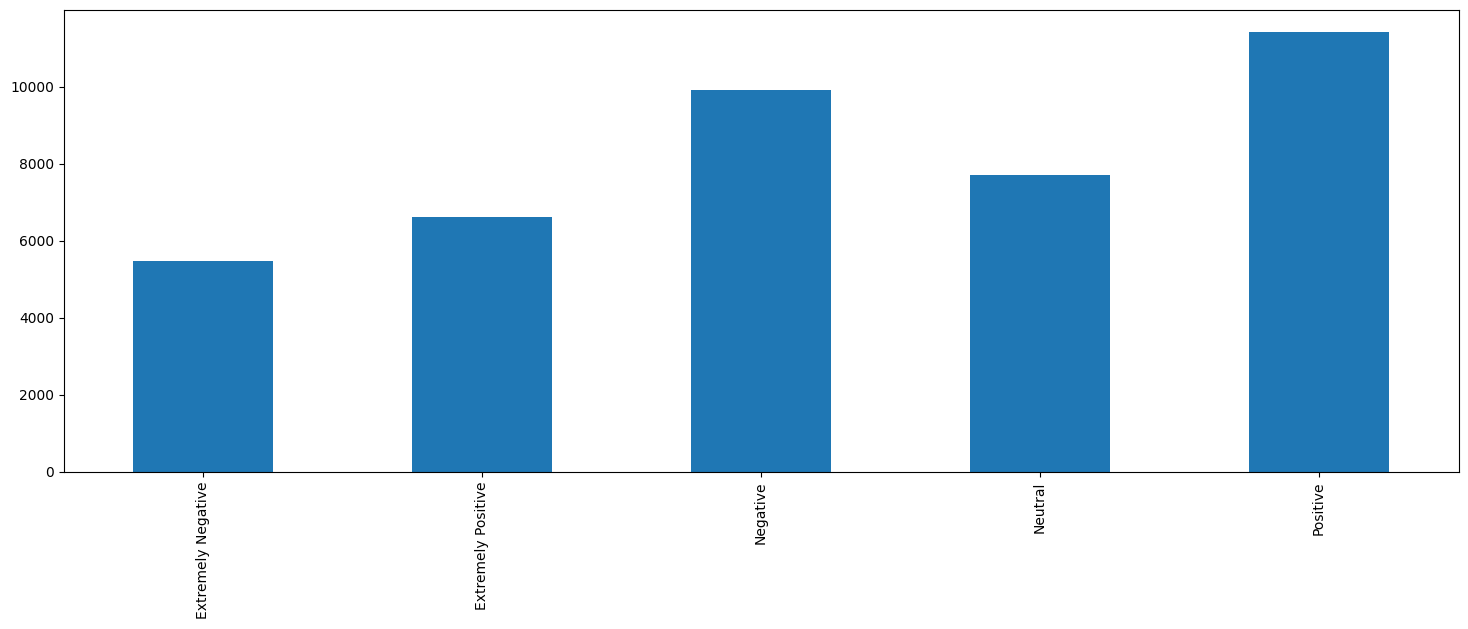

In [ ]:
# value_counts () - a command that allows you to calculate the number of unique values
vc = main_ds.Sentiment.value_counts()
vc = vc.sort_index()
print(vc)
vc.plot(kind='bar');

Дисбаланс класссов можно решить через аугментацию в следующем варианте

# Splite main_ds
Делим обучающую выборку на обучающую и валидационную.

In [ ]:
from sklearn.model_selection import train_test_split
SEED = 42

X_train, X_val, y_train, y_val = train_test_split(main_ds.Text_clean,
                                                  main_ds.Label,
                                                  stratify= main_ds.Label,
                                                  test_size=0.2,
                                                  random_state=SEED)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((32912,), (8229,), (32912,), (8229,))

# Processing Data

## torchtext tokenizer

In [ ]:
def iter_zip(seq1, seq2):
    # Создадим итератор при помощи генератора.
    for it1, it2 in zip(seq1, seq2):
        yield it1, it2

In [ ]:
train_iter = iter_zip(X_train, y_train)


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Define the tokenizer
tokenizer = get_tokenizer("basic_english")

# Define a function to yield tokens from the data iterator
def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

# Build the vocabulary from the token iterator
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])

# Set the default index for the vocabulary
vocab.set_default_index(vocab["<unk>"])

In [ ]:
vocab(['here', 'is', 'an', 'example'])

[95, 10, 69, 1286]

In [ ]:
X_train

28520    the word socialdistancing is beyond stupid dis...
16122    breaking news while toilet paper paper towels ...
2761     australian prime minister has warned people to...
20514    can borisjohnson please inform people that goi...
16536    just been at the supermarket look at the state...
                               ...                        
16969    kristin tovar was supposed to hold a grand ope...
27273    during this health emergency retail grocery an...
30716    the covid crisis has led to supermarket shelve...
3216     grocery stores are working extra hard to keep ...
27010    saw someone park their car up near a supermark...
Name: Text_clean, Length: 32912, dtype: object

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
text_pipeline(X_train.sample(1).values[0])


[89,
 841,
 380,
 104,
 3864,
 50,
 2,
 114,
 490,
 32,
 259,
 3,
 251,
 162,
 148,
 23,
 46,
 3,
 72,
 13,
 57,
 75,
 991,
 202,
 4,
 977,
 4405,
 976,
 9,
 2399,
 15,
 161]

In [ ]:
X_train = X_train.apply(text_pipeline)
X_val = X_val.apply(text_pipeline)

In [ ]:
def pad_features(x, seq_length, testing = False):
  len_text = len(x)
  if len_text<= seq_length:
    zeroes = np.zeros(seq_length-len_text)
    new = np.concatenate([zeroes,np.array(x)])
  else:
    if testing:
      new = np.array(x[0:seq_length])
    else:
      took_id = sorted(np.random.choice(np.arange(len_text), seq_length))
      new = np.array(x)[took_id]
  return new

In [ ]:
MAX_SEQ_LENTH = 45
X_train = X_train.apply(pad_features, seq_length = MAX_SEQ_LENTH, testing = False)
X_val = X_val.apply(pad_features, seq_length = MAX_SEQ_LENTH, testing = True)

## DataLoader, Dataset

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [ ]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.from_numpy(y_train.values.astype(np.int64)))
valid_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.from_numpy(y_val.values.astype(np.int64)))

In [ ]:
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size = BATCH_SIZE)

In [ ]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

In [ ]:
print('Sample input size', sample_x.size())
print('Sample input: \n', sample_x)
print('\nSample label size', sample_y.size())
print('Sample label: \n', sample_y)

Sample input size torch.Size([128, 45])
Sample input: 
 tensor([[    0,     0,     0,  ...,     1,  1917,   380],
        [    0,     0,     0,  ...,    25,     7, 31729],
        [    0,     0,     0,  ...,     8,   432,  3057],
        ...,
        [    0,     0,     0,  ...,   552, 50855,   281],
        [    0,     0,     0,  ..., 13886,     5,  1567],
        [    0,     0,     0,  ...,     3, 20991,  9170]])

Sample label size torch.Size([128])
Sample label: 
 tensor([0, 3, 3, 3, 1, 2, 3, 1, 1, 3, 3, 3, 2, 0, 1, 3, 1, 1, 2, 0, 3, 2, 0, 4,
        4, 2, 1, 1, 1, 1, 2, 1, 4, 3, 3, 0, 0, 0, 4, 3, 2, 2, 1, 1, 2, 0, 3, 1,
        3, 2, 4, 1, 1, 1, 3, 1, 3, 0, 3, 1, 0, 3, 3, 3, 3, 3, 1, 0, 0, 1, 3, 3,
        1, 3, 1, 0, 4, 0, 3, 0, 3, 0, 1, 1, 0, 3, 0, 1, 3, 0, 0, 2, 3, 4, 3, 3,
        3, 1, 4, 3, 0, 0, 1, 3, 1, 4, 0, 1, 3, 4, 4, 1, 0, 0, 1, 3, 3, 1, 0, 1,
        3, 3, 3, 0, 0, 2, 2, 0])


# Build model

In [ ]:
import torch
import torch.nn as nn

# Определение класса двунаправленной RNN для классификации текста
class TextClassBiRNN(nn.Module):
    def __init__(self, input_dim, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate):
        super(TextClassBiRNN, self).__init__()

        self.emb_dim = input_dim  # Размер входного вектора
        self.output_dim = output_dim  # Размер выходного вектора
        self.n_layers = n_layers  # Количество слоев LSTM
        self.hidden_dim = hidden_dim  # Размер скрытого состояния LSTM
        self.dropout = dropout_rate  # Вероятность отключения нейронов

        self.embedding_matrix = embedding_matrix
        # Инициализация слоя эмбеддингов с предобученной матрицей весо
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        # Инициализация LSTM слоя
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout_rate, batch_first=True)
        # Инициализация Dropout слоя
        self.dropout = nn.Dropout(dropout_rate)

        # Определение полносвязных слоев с применением BatchNorm и ReLU функций активации
        self.model1 = nn.Sequential(
            nn.Linear((hidden_dim*2 if bidirectional else hidden_dim), int((hidden_dim*2 if bidirectional else hidden_dim)/2)),
            nn.LayerNorm(int((hidden_dim*2 if bidirectional else hidden_dim)/2)),
            nn.ReLU()
        )
        self.model2 = nn.Sequential(
            nn.Linear(int((hidden_dim*2 if bidirectional else hidden_dim)/2), int((hidden_dim*2 if bidirectional else hidden_dim)/4)),
            nn.LayerNorm(int((hidden_dim*2 if bidirectional else hidden_dim)/4)),
            nn.ReLU()
        )
        self.model3 = nn.Sequential(
            nn.Linear(int((hidden_dim*2 if bidirectional else hidden_dim)/4), int((hidden_dim*2 if bidirectional else hidden_dim)/8)),
            nn.LayerNorm(int((hidden_dim*2 if bidirectional else hidden_dim)/8)),
            nn.ReLU()
        )
        self.model4 = nn.Sequential(
            nn.Linear(int((hidden_dim*2 if bidirectional else hidden_dim)/8), int((hidden_dim*2 if bidirectional else hidden_dim)/16)),
            nn.LayerNorm(int((hidden_dim*2 if bidirectional else hidden_dim)/16)),
            nn.ReLU()
        )
        self.model5 = nn.Sequential(
            nn.Linear(int((hidden_dim*2 if bidirectional else hidden_dim)/16), int((hidden_dim*2 if bidirectional else hidden_dim)/32)),
            nn.LayerNorm(int((hidden_dim*2 if bidirectional else hidden_dim)/32)),
            nn.ReLU()
        )
        self.model6 = nn.Sequential(
            nn.Linear(int((hidden_dim*2 if bidirectional else hidden_dim)/32), int((hidden_dim*2 if bidirectional else hidden_dim)/64)),
            nn.LayerNorm(int((hidden_dim*2 if bidirectional else hidden_dim)/64)),
            nn.ReLU()
        )
        self.fc7 = nn.Linear(int((hidden_dim*2 if bidirectional else hidden_dim)/64), output_dim)

    def forward(self, features):
        # Получение эмбеддингов для текста
        embedds = self.embedding(features)
        embedds = self.dropout(embedds)

        # Применение LSTM
        output, (h_n, c_n) = self.lstm(embedds)

        # Обработка выходов LSTM
        if self.lstm.bidirectional:
            h_n = self.dropout(torch.cat([h_n[-1, :, :], h_n[-2, :, :]], dim=-1))
        else:
            h_n = self.dropout(h_n[-1, :, :])

        output = self.model1(h_n)
        output = self.model2(output)
        output = self.model3(output)
        output = self.model4(output)
        output = self.model5(output)
        output = self.model6(output)
        output = self.fc7(output)

        return output


## Pretrained embedding (GloVe)

In [ ]:
#Download GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

In [ ]:
from torchtext.vocab import GloVe

In [ ]:
embedding_dim = 300  # Adjust the embedding dimension according to the GloVe file you downloaded
glove = GloVe(name='6B', dim=embedding_dim)

100%|█████████▉| 399999/400000 [00:57<00:00, 6968.94it/s]


In [ ]:
embedding_matrix = glove.get_vecs_by_tokens(vocab.get_itos(),
                                            lower_case_backup=True)

In [ ]:
vocab_size = len(vocab)
hidden_dim = 512
output_dim = NUM_CLASSES  # example output dimension
n_layers = 3
bidirectional = True
dropout_rate = 0.2



# Create the RNN model
model = TextClassBiRNN(input_dim=embedding_dim,
                     vocab_size=vocab_size,
                     embedding_matrix=embedding_matrix,
                     embedding_dim=embedding_dim,
                     hidden_dim=hidden_dim,
                     output_dim=output_dim,
                     n_layers=n_layers,
                     bidirectional=bidirectional,
                     dropout_rate=dropout_rate
                     )

In [ ]:
model

TextClassBiRNN(
  (embedding): Embedding(56399, 300)
  (lstm): LSTM(300, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (model1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (model2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (model3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (model4): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (model5): Sequential(
    (0)

mat1 and mat2 shapes cannot be multiplied (50x256 and 12800x64)

# Сonstruction train loop

Принцип построение - https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb#scrollTo=C_EsAE3VHC7-

## Functions

In [ ]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    correct = (preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
import torch

def f1_accuracy(preds, labels):

    preds_np = preds.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()

    num_classes = preds.size(1)

    preds = torch.argmax(preds, dim=1)

    f1_scores = []
    for class_idx in range(num_classes):
        TP = torch.sum((preds == class_idx) & (labels == class_idx))
        FP = torch.sum((preds == class_idx) & (labels != class_idx))
        FN = torch.sum((preds != class_idx) & (labels == class_idx))

        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        class_f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

        f1_scores.append(class_f1)

    macro_f1 = sum(f1_scores) / len(f1_scores)

    return macro_f1


# Example usage:
batch_size = 16
num_classes = 5

# Generate some random predictions and labels (assuming batch size of 16)
preds = torch.randn(batch_size, num_classes)  # Random prediction scores
labels = torch.randint(0, num_classes, (batch_size,))  # Random true labels

f1_score = f1_accuracy(preds, labels)
print("Macro F1 Score:", f1_score)



Macro F1 Score: tensor(0.)


In [ ]:
def train(model, iterator, optimizer, scheduler, criterion, accuracy):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for feature, label in iterator:
        # Put data to target device
        feature, label = feature.to(device), label.to(device)
        optimizer.zero_grad()

        logits = model(feature)

        loss = criterion(logits, label)

        predictions = torch.softmax(logits, dim=1)
        #predictions = torch.argmax(predictions, dim=1)

        acc = accuracy(predictions, label) #torch.argmax inside for F1

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        cur_lr = scheduler.get_lr()[0]

    scheduler.step()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), cur_lr

In [ ]:
def evaluate(model, iterator, criterion, accuracy):

    epoch_loss = 0
    epoch_acc = 0

    ### Testing
    model.eval()

    with torch.no_grad():

        for feature, label in iterator:
            # Put data to target device
            feature, label = feature.to(device), label.to(device)

            logits = model(feature)
            loss = criterion(logits, label)

            predictions = torch.softmax(logits, dim=1)
            #predictions = torch.argmax(predictions, dim=1)

            acc = accuracy(predictions, label) #torch.argmax inside for F1

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def predict(model, iterator, test = False):


    ### Testing
    model.eval()

    predicts = []

    with torch.no_grad():
        if test:
          for [feature] in iterator:
            # Put data to target device
            feature = feature.to(device)

            # 1. Forward pass
            test_logits = model(feature)

            # 2. Find y_pred
            test_pred = torch.softmax(test_logits.float(), dim=1)
            test_pred = torch.argmax(test_pred, dim=1)


            # 3. Caculate loss/accuracy
            predicts.append(test_pred.cpu().numpy())

        else:
          for feature, label in iterator:
              # Put data to target device
              feature, label = feature.to(device), label.to(device)

              # 1. Forward pass
              test_logits = model(feature)

              # 2. Find y_pred
              test_pred = torch.softmax(test_logits.float(), dim=1)
              test_pred = torch.argmax(test_pred, dim=1)

              # 3. Caculate loss/accuracy
              predicts.append(test_pred.cpu().numpy())

    return np.hstack(predicts)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def plot_graph(epochs, losses, accuracy, learning_rate):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].set_title("Train/Validation Loss")
    axs[0].plot(list(np.arange(epochs) + 1), losses[0], label='train')
    axs[0].plot(list(np.arange(epochs) + 1), losses[1], label='validation')
    axs[0].set(xlabel='num_epochs', ylabel='loss')

    axs[1].set_title("Train/Validation Accuracy")
    axs[1].plot(list(np.arange(epochs) + 1), accuracy[0], label='train')
    axs[1].plot(list(np.arange(epochs) + 1), accuracy[1], label='validation')
    axs[1].set(xlabel='num_epochs', ylabel='acc')

    axs[2].set_title("History learning_rate")
    axs[2].plot(list(np.arange(epochs) + 1), learning_rate)
    axs[2].set(xlabel='num_epochs', ylabel='lr')

# Run the model

[CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss)_
criterion combines ``nn.LogSoftmax()`` and ``nn.NLLLoss()`` in a single class.
It is useful when training a classification problem with C classes.
[SGD](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html)_
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0.
[StepLR](https://pytorch.org/docs/master/_modules/torch/optim/lr_scheduler.html#StepLR)_
is used here to adjust the learning rate through epochs.




In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LR_RATE = 0.01
optimizer = optim.SGD(model.parameters(), lr=LR_RATE)

#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,
                                           step_size_up=5,mode="exp_range",gamma=0.85)

In [ ]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 150

EPS = 0.9

try:
  if best_valid_loss and best_valid_acc:
    pass
except:
    best_valid_loss = float('inf')
    best_valid_acc = 0.

hist_train_loss, hist_valid_loss, hist_train_acc, hist_valid_acc = [], [], [], []
hist_lr = []

path_bestacc_model = 'best_acc_model.pt'
path_bestloss_model = 'best_loss_model.pt'

wait_train = 0
wait2end = 0

model_saved = False

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, ep_lr = train(model, train_loader, optimizer,
                                         lr_scheduler, criterion, f1_accuracy)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(train_acc)

    valid_loss, valid_acc = evaluate(model, valid_loader, criterion,
                                     f1_accuracy)
    hist_valid_loss.append(valid_loss)
    hist_valid_acc.append(valid_acc)
    hist_lr.append(ep_lr)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    text_add = ''
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_bestloss_model)

        model_saved = True
        text_add = ' - save best_loss_model'
        wait2end = 0
        wait_train = 0
        k = 0

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), path_bestacc_model)

        model_saved = True
        text_add += ' - save best_acc_model'
        wait2end = 0
        wait_train = 0
        k = 1

    else:
        wait_train+=1


    if wait_train > 5 and model_saved:
       if k == 0:
         model.load_state_dict(torch.load(path_bestloss_model))
         text_add = ' - best_loss_model'

       elif k == 1:
         model.load_state_dict(torch.load(path_bestacc_model))
         text_add = ' - best_acc_model'
       LR_RATE *= EPS
       lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR_RATE, max_lr=0.1,
                                           step_size_up=5,mode="exp_range",gamma=0.85)
       wait_train = 0
       wait2end+=1

    print(f'Epoch: {epoch+1:02} | with lr: {ep_lr:.9f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain_Loss: {train_loss:.3f} | Train_Acc: {train_acc*100:.2f}%  Val_Loss: {valid_loss:.3f} | Val_Acc: {valid_acc*100:.2f}%' + text_add)

    if wait2end > 5:
      print('Stop train, do not best fitness')
      model.load_state_dict(torch.load(path_bestloss_model))

Epoch: 01 | with lr: 0.030870242 | Epoch Time: 0m 54s
	Train Loss: 1.447 | Train Acc: 26.12% Val. Loss: 1.438 |  Val. Acc: 24.01% - save best_loss_model - save best_acc_model
Epoch: 02 | with lr: 0.020042279 | Epoch Time: 0m 54s
	Train Loss: 1.425 | Train Acc: 28.78% Val. Loss: 1.419 |  Val. Acc: 29.09% - save best_loss_model - save best_acc_model
Epoch: 03 | with lr: 0.011790625 | Epoch Time: 0m 54s
	Train Loss: 1.404 | Train Acc: 31.76% Val. Loss: 1.370 |  Val. Acc: 33.33% - save best_loss_model - save best_acc_model
Epoch: 04 | with lr: 0.005586016 | Epoch Time: 0m 54s
	Train Loss: 1.382 | Train Acc: 33.48% Val. Loss: 1.359 |  Val. Acc: 34.04% - save best_loss_model - save best_acc_model
Epoch: 05 | with lr: 0.001000000 | Epoch Time: 0m 54s
	Train Loss: 1.368 | Train Acc: 34.26% Val. Loss: 1.352 |  Val. Acc: 34.90% - save best_loss_model - save best_acc_model
Epoch: 06 | with lr: 0.004313396 | Epoch Time: 0m 54s
	Train Loss: 1.366 | Train Acc: 34.39% Val. Loss: 1.344 |  Val. Acc: 35

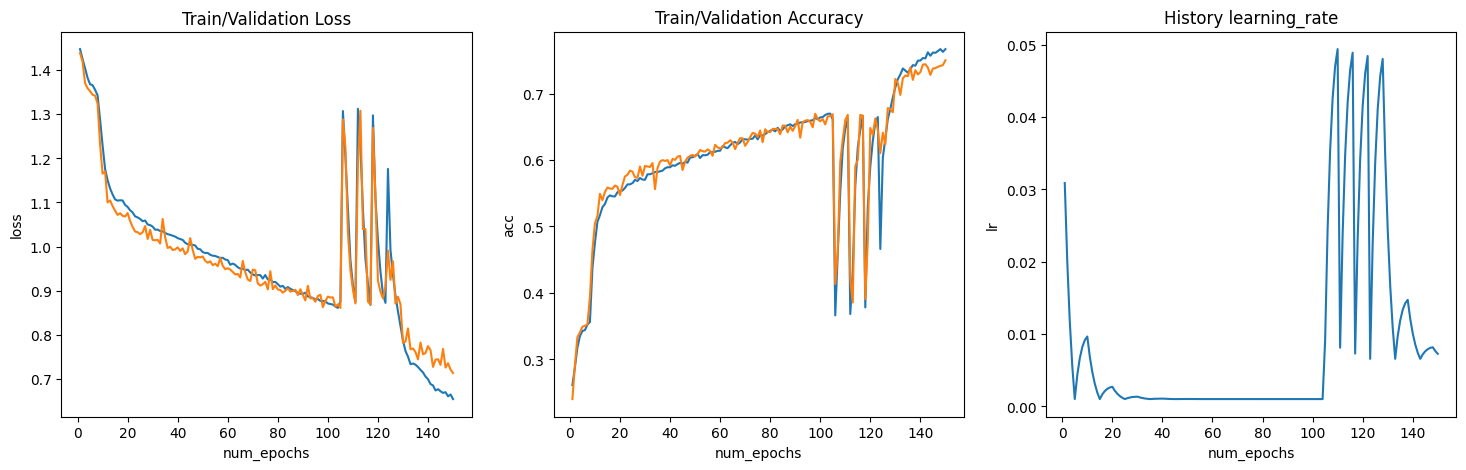

In [ ]:
train_ephs = len(hist_train_loss)
losses = (hist_train_loss, hist_valid_loss)
accuracy = (hist_train_acc, hist_valid_acc)
plot_graph(train_ephs, losses, accuracy, hist_lr)

## next train with class_weights

In [ ]:
# Calculate class frequencies
class_frequencies = main_ds.Label.value_counts().sort_index()

# Calculate class weights inversely proportional to class frequencies
total_samples = len(main_ds)
class_weights = total_samples / (len(class_frequencies) * class_frequencies)

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 150

EPS = 0.9

try:
  if best_valid_loss and best_valid_acc:
    pass
except:
    best_valid_loss = float('inf')
    best_valid_acc = 0.

hist_train_loss, hist_valid_loss, hist_train_acc, hist_valid_acc = [], [], [], []
hist_lr = []

path_bestacc_model = 'best_acc_model.pt'
path_bestloss_model = 'best_loss_model.pt'

wait_train = 0
wait2end = 0

model_saved = False

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, ep_lr = train(model, train_loader, optimizer,
                                         lr_scheduler, criterion, f1_accuracy)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(train_acc)

    valid_loss, valid_acc = evaluate(model, valid_loader, criterion,
                                     f1_accuracy)
    hist_valid_loss.append(valid_loss)
    hist_valid_acc.append(valid_acc)
    hist_lr.append(ep_lr)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    text_add = ''
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_bestloss_model)

        model_saved = True
        text_add = ' - save best_loss_model'
        wait2end = 0
        wait_train = 0
        k = 0

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), path_bestacc_model)

        model_saved = True
        text_add += ' - save best_acc_model'
        wait2end = 0
        wait_train = 0
        k = 1

    else:
        wait_train+=1


    if wait_train > 5 and model_saved:
       if k == 0:
         model.load_state_dict(torch.load(path_bestloss_model))
         text_add = ' - load best_loss_model'

       elif k == 1:
         model.load_state_dict(torch.load(path_bestacc_model))
         text_add = ' - load best_acc_model'
       LR_RATE *= EPS
       lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR_RATE, max_lr=0.1,
                                           step_size_up=5,mode="exp_range",gamma=0.85)
       wait_train = 0
       wait2end+=1

    print(f'Epoch: {epoch+1:02} | with lr: {ep_lr:.9f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain_Loss: {train_loss:.3f} | Train_Acc: {train_acc*100:.2f}%  Val_Loss: {valid_loss:.3f} | Val_Acc: {valid_acc*100:.2f}%' + text_add)

    if wait2end > 5:
      print('Stop train, do not best fitness')
      model.load_state_dict(torch.load(path_bestloss_model))
      break

Epoch: 01 | with lr: 0.006955746 | Epoch Time: 0m 52s
	Train_Loss: 0.624 | Train_Acc: 76.65%  Val_Loss: 0.699 | Val_Acc: 73.46% - save best_loss_model
Epoch: 02 | with lr: 0.006728767 | Epoch Time: 0m 55s
	Train_Loss: 0.619 | Train_Acc: 76.78%  Val_Loss: 0.719 | Val_Acc: 74.77%
Epoch: 03 | with lr: 0.006561000 | Epoch Time: 0m 54s
	Train_Loss: 0.618 | Train_Acc: 77.02%  Val_Loss: 0.695 | Val_Acc: 74.24% - save best_loss_model
Epoch: 04 | with lr: 0.006682212 | Epoch Time: 0m 54s
	Train_Loss: 0.609 | Train_Acc: 77.00%  Val_Loss: 0.708 | Val_Acc: 74.12%
Epoch: 05 | with lr: 0.006767060 | Epoch Time: 0m 54s
	Train_Loss: 0.608 | Train_Acc: 77.28%  Val_Loss: 0.699 | Val_Acc: 74.87%
Epoch: 06 | with lr: 0.006823727 | Epoch Time: 0m 54s
	Train_Loss: 0.608 | Train_Acc: 76.81%  Val_Loss: 0.688 | Val_Acc: 75.03% - save best_loss_model - save best_acc_model
Epoch: 07 | with lr: 0.006858757 | Epoch Time: 0m 54s
	Train_Loss: 0.610 | Train_Acc: 77.03%  Val_Loss: 0.720 | Val_Acc: 74.21%
Epoch: 08 | w

KeyboardInterrupt: ignored

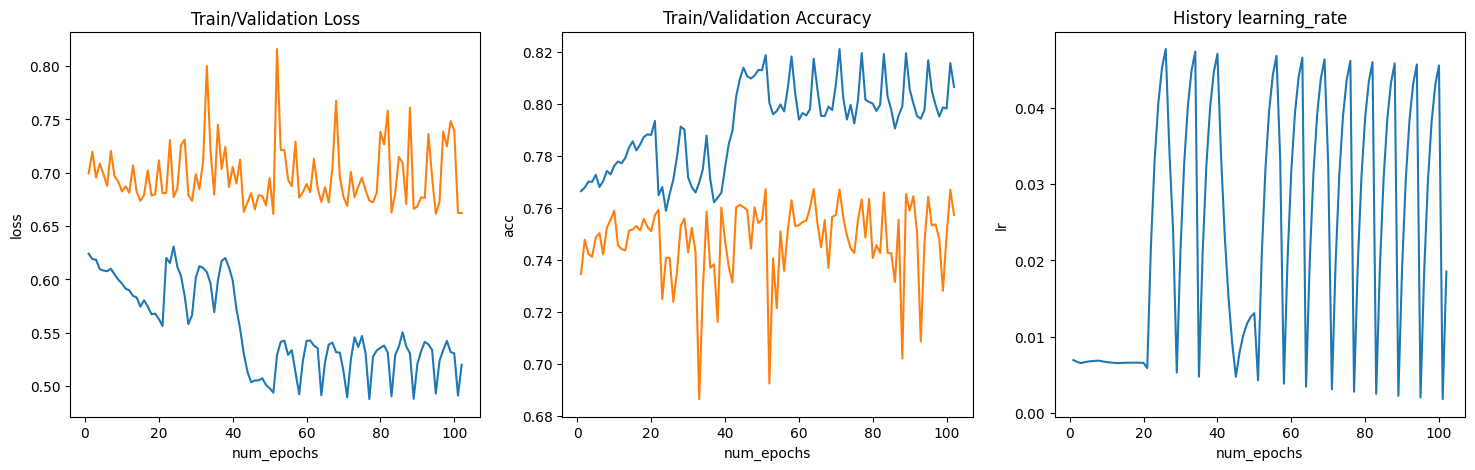

In [ ]:
train_ephs = len(hist_train_loss)
losses = (hist_train_loss, hist_valid_loss)
accuracy = (hist_train_acc, hist_valid_acc)
plot_graph(train_ephs, losses, accuracy, hist_lr)

## next train

In [ ]:
N_EPOCHS = 200

EPS = 0.7


JDUN_TRAIN = 3
JDUN_END = 10

try:
  if best_valid_loss and best_valid_acc:
    pass
except:
    best_valid_loss = float('inf')
    best_valid_acc = 0.

hist_train_loss, hist_valid_loss, hist_train_acc, hist_valid_acc = [], [], [], []
hist_lr = []

path_bestacc_model = 'best_acc_model.pt'
path_bestloss_model = 'best_loss_model.pt'

wait_train = 0
wait2end = 0

model_saved = True

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, ep_lr = train(model, train_loader, optimizer,
                                         lr_scheduler, criterion, f1_accuracy)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(train_acc)

    valid_loss, valid_acc = evaluate(model, valid_loader, criterion,
                                     f1_accuracy)
    hist_valid_loss.append(valid_loss)
    hist_valid_acc.append(valid_acc)
    hist_lr.append(ep_lr)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    text_add = ''
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_bestloss_model)

        model_saved = True
        text_add = ' - save best_loss_model'
        wait2end = 0
        wait_train = 0
        k = 0

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), path_bestacc_model)

        model_saved = True
        text_add += ' - save best_acc_model'
        wait2end = 0
        wait_train = 0
        k = 1

    else:
        wait_train+=1


    if wait_train > JDUN_TRAIN and model_saved:
       if k == 0:
         model.load_state_dict(torch.load(path_bestloss_model))
         text_add = ' - load best_loss_model'

       elif k == 1:
         model.load_state_dict(torch.load(path_bestacc_model))
         text_add = ' - load best_acc_model'
       LR_RATE *= EPS
       lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR_RATE, max_lr=0.1,
                                           step_size_up=5,mode="exp_range",gamma=0.85)
       wait_train = 0
       wait2end+=1

    print(f'Epoch: {epoch+1:02} | with lr: {ep_lr:.9f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain_Loss: {train_loss:.3f} | Train_Acc: {train_acc*100:.2f}%  Val_Loss: {valid_loss:.3f} | Val_Acc: {valid_acc*100:.2f}%' + text_add)

    if wait2end > JDUN_END:

      if k == 0:
        model.load_state_dict(torch.load(path_bestloss_model))
        text_add = ' - load best_loss_model'

      elif k == 1:
        model.load_state_dict(torch.load(path_bestacc_model))
        text_add = ' - load best_acc_model'

      print('Stop train, do not best fitness'+ text_add)

      break

Epoch: 01 | with lr: 0.020731224 | Epoch Time: 0m 55s
	Train_Loss: 0.477 | Train_Acc: 82.35%  Val_Loss: 0.680 | Val_Acc: 75.49%
Epoch: 02 | with lr: 0.012550669 | Epoch Time: 0m 54s
	Train_Loss: 0.462 | Train_Acc: 82.78%  Val_Loss: 0.697 | Val_Acc: 76.09%
Epoch: 03 | with lr: 0.006399521 | Epoch Time: 0m 54s
	Train_Loss: 0.446 | Train_Acc: 83.51%  Val_Loss: 0.701 | Val_Acc: 75.79%
Epoch: 04 | with lr: 0.001853020 | Epoch Time: 0m 54s
	Train_Loss: 0.429 | Train_Acc: 84.05%  Val_Loss: 0.693 | Val_Acc: 76.72% - load best_acc_model
Epoch: 05 | with lr: 0.001297114 | Epoch Time: 0m 54s
	Train_Loss: 0.493 | Train_Acc: 81.73%  Val_Loss: 0.675 | Val_Acc: 76.57%
Epoch: 06 | with lr: 0.018076605 | Epoch Time: 0m 54s
	Train_Loss: 0.520 | Train_Acc: 80.45%  Val_Loss: 0.675 | Val_Acc: 75.96%
Epoch: 07 | with lr: 0.029822248 | Epoch Time: 0m 54s
	Train_Loss: 0.538 | Train_Acc: 79.97%  Val_Loss: 0.733 | Val_Acc: 72.44%
Epoch: 08 | with lr: 0.037666660 | Epoch Time: 0m 54s
	Train_Loss: 0.546 | Train_A

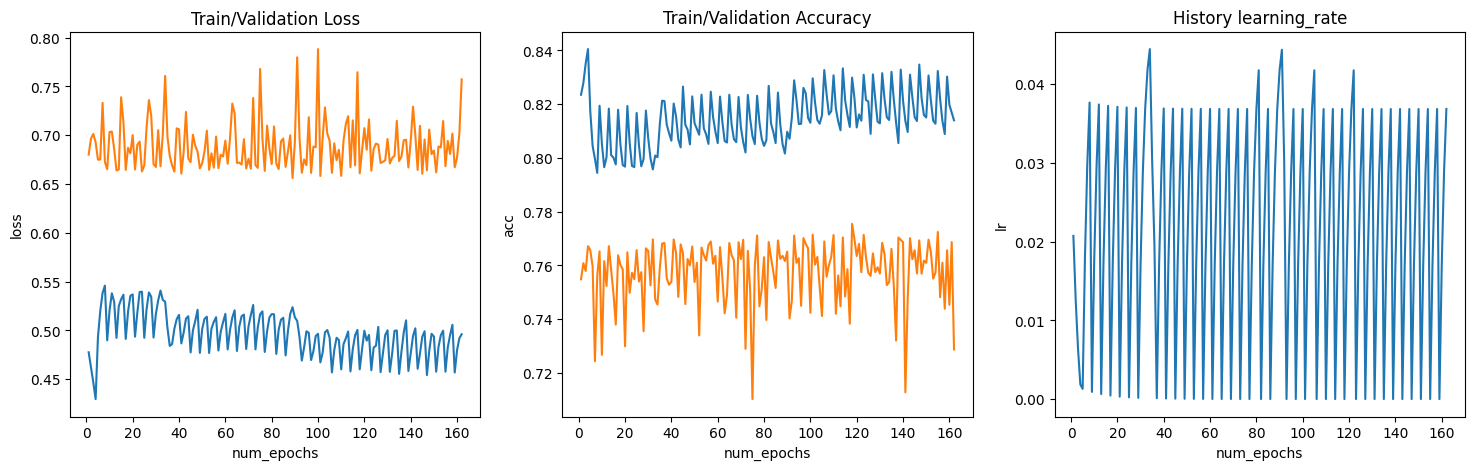

In [ ]:
train_ephs = len(hist_train_loss)
losses = (hist_train_loss, hist_valid_loss)
accuracy = (hist_train_acc, hist_valid_acc)
plot_graph(train_ephs, losses, accuracy, hist_lr)

## plot_confusion_matrix

In [ ]:
!pip install scikit-plot -q
import scikitplot as skplt

In [ ]:
pred_lbls = predict(model, valid_loader)

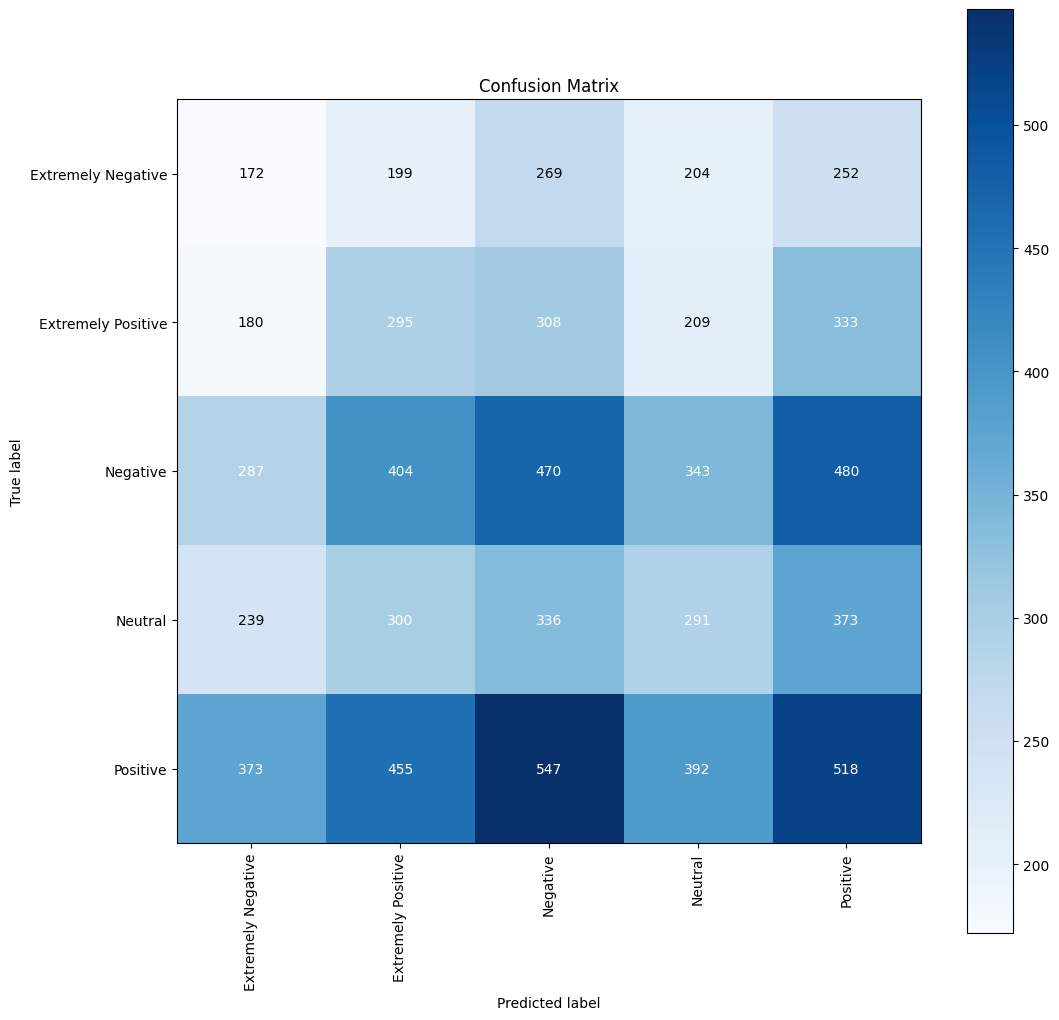

In [ ]:
y_true = [dict_lbl_to_sent[x] for x in y_val]
y_pred = [dict_lbl_to_sent[x] for x in pred_lbls]
skplt.metrics.plot_confusion_matrix(
    y_true,
    y_pred,
    figsize=(12,12),x_tick_rotation=90);

# Predict test

In [ ]:
from tqdm import tqdm

In [ ]:
#model.load_state_dict(torch.load('best_acc_model.pt'))
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)
sentiments = []
X_test = test_ds['Text_clean'].apply(text_pipeline).apply(pad_features,
                                                        seq_length = MAX_SEQ_LENTH,
                                                        testing = True)
model.eval()
with torch.inference_mode():
    for feature in tqdm(X_test.values, total=X_test.shape[0]):
        feature = torch.tensor([feature], dtype=torch.long)

        # Place the tokenized sentence and its attention mask tensors on defined device
        feature = feature.to(device)
        # Get predictions
        logits = model(feature)
        pred = torch.argmax(logits).cpu().numpy().item()
        # Convert the integer category value to its actual name and save in predictions list
        sentiments.append(dict_lbl_to_sent[pred])

# Save the predictions in Pandas column
test_ds['Sentiment'] = sentiments

100%|██████████| 3798/3798 [00:24<00:00, 154.85it/s]


In [ ]:
sample_submission.Sentiment = test_ds['Sentiment'].values
sample_submission.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Extremely Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


# Сабмит в Kaggle сразу

In [ ]:
file_name = 'submission.csv'
# сохраняем с колонкой Id
sample_submission.to_csv(file_name, index=False)

Старый для проб

In [ ]:
!kaggle competitions submit -c nlp-txt-classification -f submission.csv -m "from colab_tests"

100% 182k/182k [00:02<00:00, 78.7kB/s]
Successfully submitted to Unit 3 - Text Classification

Основной

In [ ]:
!kaggle competitions submit -c unit-3-nlp-txt-classification -f submission.csv -m "From colab - besline BW_NN"

100% 182k/182k [00:02<00:00, 75.2kB/s]
Successfully submitted to Unit 3 - Классификация текстов